# Translate seq2seq Mechanism Attention  
По примеру https://blog.paperspace.com/seq-to-seq-attention-mechanism-keras/


#Step 1: Import the Dataset

In [ ]:
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip

['Archive:  fra-eng.zip',
 '  inflating: _about.txt              ',
 '  inflating: fra.txt                 ']

In [ ]:
# Get the txt file which has English -> French translation
path_to_file = "fra.txt"

#Step 2: Preprocess the Dataset
The dataset has Unicode characters, which have to be normalized.

Moreover, all the tokens in the sequences have to be cleaned using the regular expressions library.

Remove unwanted spaces, include a space between every word and the punctuation following it (to differentiate between both), replace unwanted characters with spaces, and append <start> and <end> tokens to specify the start and end of a sequence.

Encapsulate the unicode conversion in a function unicode_to_ascii() and sequence preprocessing in a function preprocess_sentence().

In [ ]:
import unicodedata

import re

# Convert the unicode sequence to ascii
# вот этого у нас не было
def unicode_to_ascii(s):

  # Normalize the unicode string and remove the non-spacking mark
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# Preprocess the sequence
def preprocess_sentence(w):

  # Clean the sequence
  w = unicode_to_ascii(w.lower().strip())

  # Create a space between word and the punctuation following it
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",")
  #w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  # сделаем универсальным и для русских текстов
  w = re.sub(r"[^a-zA-Zа-яёА-ЯЁ?.!,;:¿]+", " ", w) # добавим еще букуву '¿' из оригинала
  # Перевёрнутый вопросительный знак в испанском языке ставят в начале вопросительного предложения 
  #и он является усиливающим дополнением к традиционному во всех языках вопросительному знаку.

  w = w.strip()

  # Add a start and stop token to detect the start and end of the sequence
  w = '<start> ' + w + ' <end>'
  return w

#Step 3: Prepare the Dataset

In [ ]:
#Next, prepare a dataset out of the raw data we have. Create word pairs combining the English sequences and their related French sequences.

import io

# Create the Dataset
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  # Loop through lines (sequences) and extract the English and French sequences. Store them as a word-pair
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t', 2)[:-1]]  for l in lines[:num_examples]]
  return zip(*word_pairs)

In [ ]:
# Check if the dataset has been created properly.

%time en, fra = create_dataset(path_to_file, None)
print(en[-1])
print(fra[-1])

CPU times: user 9.32 s, sys: 245 ms, total: 9.57 s
Wall time: 9.57 s
<start> it may be impossible to get a completely error free corpus due to the nature of this kind of collaborative effort . however , if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning , we might be able to minimize errors . <end>
<start> il est peut etre impossible d obtenir un corpus completement denue de fautes , etant donnee la nature de ce type d entreprise collaborative . cependant , si nous encourageons les membres a produire des phrases dans leurs propres langues plutot que d experimenter dans les langues qu ils apprennent , nous pourrions etre en mesure de reduire les erreurs . <end>


Now tokenize the sequences. Tokenization is the mechanism of creating an internal vocabulary comprising English and French tokens (i.e. words), converting the tokens (or, in general, sequences) to integers, and padding them all to make the sequences possess the same length. All in all, tokenization facilitates the model training process.

Create a function tokenize() to encapsulate all the above-mentioned requirements.

In [ ]:
# Тоже стнадартно
import tensorflow as tf

# Convert sequences to tokenizers
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  
  # Convert sequences into internal vocab
  lang_tokenizer.fit_on_texts(lang)

  # Convert internal vocab to numbers
  tensor = lang_tokenizer.texts_to_sequences(lang)

  # Pad the tensors to assign equal length to all the sequences
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  # обрезает по длине максимально длинного предложения в корпусе текста

  return tensor, lang_tokenizer

In [ ]:
#Load the tokenized dataset by calling the create_dataset() and tokenize() functions.

# Load the dataset
def load_dataset(path, num_examples=None):
 
  # Create dataset (targ_lan = English, inp_lang = French)
  targ_lang, inp_lang = create_dataset(path, num_examples)

  # Tokenize the sequences
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# Reduce the number of data samples required to train the model. Employing the whole dataset will consume a lot more time for training the model.

# Consider 50k examples
num_examples = 50000
%time input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
# тоже более простой способ определения max_length_targ, max_length_inp

CPU times: user 4.2 s, sys: 138 ms, total: 4.34 s
Wall time: 4.31 s


In [ ]:
print(max_length_targ, max_length_inp)

11 19


#Step 4: Create the Dataset

In [ ]:
# Segregate the train and validation datasets.

#!pip3 install sklearn

from sklearn.model_selection import train_test_split

# Create training and validation sets using an 80/20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

40000 40000 10000 10000


In [ ]:
#Validate the mapping that’s been created between the tokens of the sequences and the indices.

# Show the mapping b/w word index and language tokenizer
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      try:
        el_seq = lang.index_word[t]
        print ("%d ----> %s" % (t, el_seq)) # lang.index_word[t]))
      except:
        print ("There is no word whith index '%05i' in the dictionary " % (t ))
      
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
81 ----> on
68 ----> se
1329 ----> voit
271 ----> demain
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
37 ----> ll
80 ----> see
5 ----> you
277 ----> tomorrow
3 ----> .
2 ----> <end>


In [ ]:
# проверим на отсутсвующие слова
#convert(targ_lang, '<start> по русски <end>')
print(target_tensor_train[0])
#convert(targ_lang, np.array([1, 100000, 2])) #'<start> faisons <end>')
convert(targ_lang, [1, 100000, 2]) 
# подправим на отсуствующие слова

[  1   4  37  80   5 277   3   2   0   0   0]
1 ----> <start>
There is no word whith index '100000' in the dictionary 
2 ----> <end>


#Step 5: Initialize the Model Parameters
With the dataset in hand, start initializing the model parameters.

- BUFFER_SIZE: Total number of input/target samples. In our model, it’s 40,000.
- BATCH_SIZE: Length of the training batch.
- steps_per_epoch: The number of steps per epoch. Computed by dividing - BUFFER_SIZE by BATCH_SIZE.
- embedding_dim: Number of nodes in the embedding layer.
- units: Hidden units in the network.
- vocab_inp_size: Length of the input (French) vocabulary.
- vocab_tar_size: Length of the output (English) vocabulary.

In [ ]:
# Essential model parameters
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

In [ ]:
#Next, call the tf.data.Dataset API and create a proper dataset.

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# Size of input and target batches
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 19]), TensorShape([64, 11]))

#Step 6: Encoder Class
The first step in creating an encoder-decoder sequence-to-sequence model (with an attention mechanism) is creating an encoder. For the application at hand, create an encoder with an embedding layer followed by a GRU (Gated Recurrent Unit) layer. The input goes through the embedding layer first and then into the GRU layer. The GRU layer outputs both the encoder network output and the hidden state.

Enclose the model’s __init__() and call() methods in a class Encoder.

In the method, __init__(), initializes the batch size and encoding units. Add an embedding layer that accepts vocab_size as the input dimension and embedding_dim as the output dimension. Also, add a GRU layer that accepts units (dimensionality of the output space) and the first hidden dimension.

In the method call(), define the forward propagation that has to happen through the encoder network.

Moreover, define a method initialize_hidden_state() to initialize the hidden state with the dimensions batch_size and units.

Add the following code as part of your Encoder class.



In [ ]:
# Encoder class
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units

    # Embed the vocab to a dense embedding 
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    # GRU Layer
    # glorot_uniform: Initializer for the recurrent_kernel weights matrix, 
    # used for the linear transformation of the recurrent state
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  # Encoder network comprises an Embedding layer followed by a GRU layer
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  # To initialize the hidden state
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
#Call the encoder class to check the shapes of the encoder output and hidden state.

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))


Encoder output shape: (batch size, sequence length, units) (64, 19, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


#Step 7: Attention Mechanism Class
This step captures the attention mechanism.

Compute the sum (or product) of the encoder’s outputs and decoder states.
- Pass the generated output through a fully-connected network.
- Apply softmax activation to the output. This gives the attention weights.
- Create the context vector by computing the weighted sum of attention weights and encoder’s outputs.

Everything thus far needs to be captured in a class BahdanauAttention. 

Bahdanau Attention is also called the “Additive Attention”, a Soft Attention technique. As this is additive attention, we do the sum of the encoder’s outputs and decoder hidden state (as mentioned in the first step).

This class has to have __init__() and call() methods.

In the __init__() method, initialize three Dense layers: one for the decoder state ('units' is the size), another for the encoder’s outputs ('units' is the size), and the other for the fully-connected network (one node).

In the call() method, initialize the decoder state (s0) by taking the final encoder hidden state. 
- Pass the generated decoder hidden state through one dense layer. 
- Also, plug the encoder’s outputs through the other dense layer. 
- Add both the outputs, encase them in a tanh activation and plug them into the fully-connected layer. 

This fully-connected layer has one node; thus, the final output has the dimensions batch_size * max_length of the sequence * 1.

Later, apply softmax on the output of the fully-connected network to generate the attention weights.

Compute the context_vector by performing a weighted sum of the attention weights and the encoder’s outputs.



In [ ]:
# Attention Mechanism
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # values shape == (batch_size, max_len, hidden size)

    # we are doing this to broadcast addition along the time axis to calculate the score
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
#Validate the shapes of the attention weights and its output.

attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 19, 1)


sample_hidden here is the hidden state of the encoder, and sample_output denotes the encoder’s outputs.

#Step 8: Decoder Class
This step encapsulates the decoding mechanism. The Decoder class has to have two methods: __init__() and call().

In the __init__() method, initialize the batch size, decoder units, embedding dimension, GRU layer, and a Dense layer. Also, create an instance of the BahdanauAttention class.

In the call() method:
- Call the attention forward propagation and capture the context vector and attention weights.
- Send the target token through an embedding layer.
- Concatenate the embedded output and context vector.
- Plug the output into the GRU layer and then into a fully-connected layer.

Add the following code to define the Decoder class.

In [ ]:
## Decoder class
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # Used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # x shape == (batch_size, 1)
    # hidden shape == (batch_size, max_length)
    # enc_output shape == (batch_size, max_length, hidden_size)

    # context_vector shape == (batch_size, hidden_size)
    # attention_weights shape == (batch_size, max_length, 1)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab_size)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
#Validate the decoder output shape.

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 5918)


#Step 9: Optimizer and Loss Functions
Define the optimizer and loss functions.

As the input sequences are being padded with zeros, nullify the loss when there’s a zero in the real value.

In [ ]:
# Initialize optimizer and loss functions
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Loss function
def loss_function(real, pred):

  # Take care of the padding. Not all sequences are of equal length.
  # If there's a '0' in the sequence, the loss is being nullified
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

#Step 10: Train the Model
Checkpoint your model’s weights during training. This helps in the automatic retrieval of the weights while evaluating the model.



In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

Next, define the training procedure. First, call the encoder class and procure the encoder outputs and final hidden state. Initialize the decoder input to have the <start> token spread across all the input sequences (indicated using the BATCH_SIZE). 

Use the teacher forcing technique to iterate over all decoder states by feeding the target as the next input. This loop continues until every token in the target sequence (English) is visited.

Call the decoder class with decoder input, decoder hidden state, and encoder’s outputs. Procure the decoder output and hidden state. Compute the loss by comparing the real against the predicted value of the target. Fetch the target token and feed it to the next decoder state (concerning the successive target token). Also, make a note that the target decoder hidden state will be the next decoder hidden state.

After the teacher forcing technique gets finished, compute the batch loss, and run the optimizer to update the model's variables.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  # tf.GradientTape() -- record operations for automatic differentiation
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # dec_hidden is used by attention, hence is the same enc_hidden
    dec_hidden = enc_hidden

    # <start> token is the initial decoder input
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):

      # Pass enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      # Compute the loss
      loss += loss_function(targ[:, t], predictions)

      # Use teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  # As this function is called per batch, compute the batch_loss
  batch_loss = (loss / int(targ.shape[1]))

  # Get the model's variables
  variables = encoder.trainable_variables + decoder.trainable_variables

  # Compute the gradients
  gradients = tape.gradient(loss, variables)

  # Update the variables of the model/network
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

Now initialize the actual training loop. Run your loop over a specified number of epochs. First, initialize the encoder hidden state using the method initialize_hidden_state(). Loop through the dataset one batch at a time (per epoch). Call the train_step() method per batch and compute the loss. Continue until all the epochs have been covered.

In [ ]:
import time

EPOCHS = 30

# Training loop
for epoch in range(EPOCHS):
  start = time.time()

  # Initialize the hidden state
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  # Loop through the dataset
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

    # Call the train method
    batch_loss = train_step(inp, targ, enc_hidden)

    # Compute the loss (per batch)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # Save (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  # Output the loss observed until that epoch
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.8492
Epoch 1 Batch 100 Loss 2.1289
Epoch 1 Batch 200 Loss 1.8440
Epoch 1 Batch 300 Loss 1.7853
Epoch 1 Batch 400 Loss 1.5270
Epoch 1 Batch 500 Loss 1.5625
Epoch 1 Batch 600 Loss 1.2629
Epoch 1 Loss 1.8229
Time taken for 1 epoch 144.36796307563782 sec

Epoch 2 Batch 0 Loss 1.3848
Epoch 2 Batch 100 Loss 1.3468
Epoch 2 Batch 200 Loss 1.0773
Epoch 2 Batch 300 Loss 1.0205
Epoch 2 Batch 400 Loss 0.9292
Epoch 2 Batch 500 Loss 0.8865
Epoch 2 Batch 600 Loss 0.8973
Epoch 2 Loss 1.0452
Time taken for 1 epoch 128.30960702896118 sec

Epoch 3 Batch 0 Loss 0.7059
Epoch 3 Batch 100 Loss 0.6930
Epoch 3 Batch 200 Loss 0.5542
Epoch 3 Batch 300 Loss 0.6007
Epoch 3 Batch 400 Loss 0.5907
Epoch 3 Batch 500 Loss 0.7067
Epoch 3 Batch 600 Loss 0.6093
Epoch 3 Loss 0.6262
Time taken for 1 epoch 127.52085089683533 sec

Epoch 4 Batch 0 Loss 0.4589
Epoch 4 Batch 100 Loss 0.3567
Epoch 4 Batch 200 Loss 0.3951
Epoch 4 Batch 300 Loss 0.2587
Epoch 4 Batch 400 Loss 0.3725
Epoch 4 Batch 500 Loss 0.48

#Step 11: Test the Model
Now define your model evaluation procedure. First, take the sentence given by the user into consideration. This has to be given in the French language. The model now has to convert the sentence from French to English.

Initialize an empty attention plot to be plotted later on with max_length_target on the Y-axis, and max_length_input on the X-axis.

Preprocess the sentence and convert it into tensors.

Then plug the sentence into the model.

Initialize an empty hidden state which is to be used while initializing an encoder. Usually, the initialize_hidden_state() method in the encoder class gives the hidden state having the dimensions batch_size * hidden_units. Now, as the batch size is 
1
, the initial hidden state has to be manually initialized.

Call the encoder class and procure the encoder outputs and final hidden state.

By looping over max_length_targ, call the decoder class wherein the dec_input is the <start> token, dec_hidden state is the encoder hidden state, and enc_out is the encoder’s outputs. Procure the decoder output, hidden state, and attention weights.

Create a plot using the attention weights. Fetch the predicted token with the maximum attention. Append the token to the result and continue until the <end> token is reached.

The next decoder input will be the previously predicted index (concerning the token).

Add the following code as part of the evaluate() function.



In [ ]:
import numpy as np

# Evaluate function -- similar to the training loop
def evaluate(sentence):

  # Attention plot (to be plotted later on) -- initialized with max_lengths of both target and input
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  # Preprocess the sentence given
  sentence = preprocess_sentence(sentence)

  # Fetch the indices concerning the words in the sentence and pad the sequence
  #inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  # подпрвиv, чтобы не выскакивала ошибка на незнакомое слово
  
  inputs = []
  for i in sentence.split(' '):
    try:
      ind_inp = inp_lang.word_index[i]
      inputs.append(ind_inp)
    except KeyError:
      #ind_inp = 100000
      #print( f"В словаре нет слова '{i}'")
      print ("There is no word '%s' in the dictionary " % (i ))
    
  

  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  # Convert the inputs to tensors
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  # Loop until the max_length is reached for the target lang (ENGLISH)
  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # Store the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    # Get the prediction with the maximum attention
    predicted_id = tf.argmax(predictions[0]).numpy()

    # Append the token to the result
    result += targ_lang.index_word[predicted_id] + ' '

    # If <end> token is reached, return the result, input, and attention plot
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # The predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

#Step 12: Plot and Predict
Define the plot_attention() function to plot the attention statistics.



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
#Define a function translate() which internally calls the evaluate() function.

# Translate function (which internally calls the evaluate function)
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# Restore the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> as tu lu ce livre ? <end>
Predicted translation: did you read that book ? <end> 


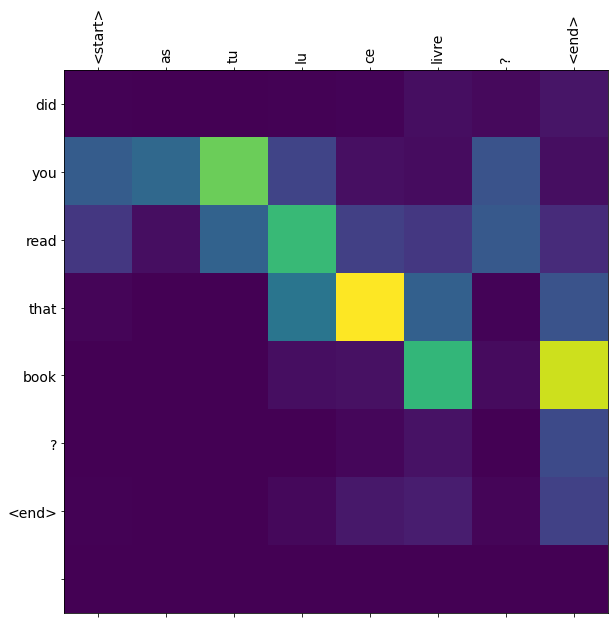

In [ ]:
#Call the translate() function by inputting a few sentences in French.

translate(u"As tu lu ce livre?")
# The actual translation is "Have you read this book?"

There is no word 'вас' in the dictionary 
There is no word 'тут' in the dictionary 
There is no word 'не' in the dictionary 
There is no word 'стояло' in the dictionary 
Input: <start> as tu lu ce livre ? вас тут не стояло <end>
Predicted translation: did you read that book ? <end> 


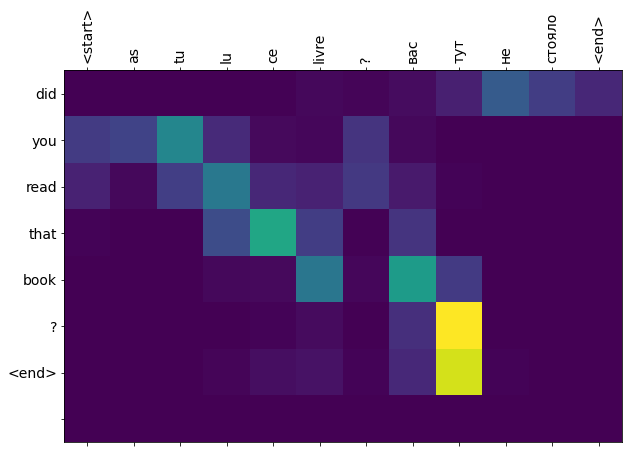

In [ ]:
# Проверим с отсутсвующим словом
translate(u"As tu lu ce livre? Вас тут не стояло")
# The actual translation is "Have you read this book?"

Input: <start> comment as tu ete ? <end>
Predicted translation: how did you been ? <end> 


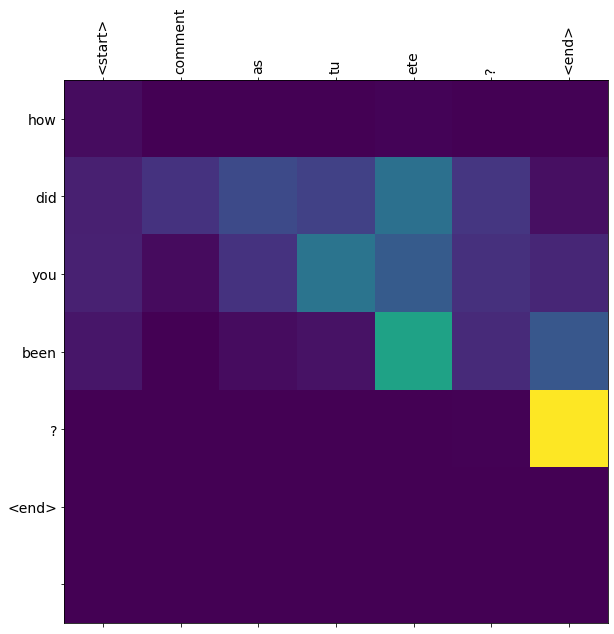

In [ ]:
translate(u"Comment as-tu été?")
# The actual translation is "How have you been?"